In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from base64 import b64encode
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import HTML, display
from tqdm.notebook import tqdm
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import TimesformerModel, TimesformerConfig
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from torchinfo import summary
import copy

2025-06-14 09:37:50.600806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749893870.806882      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749893870.871461      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
features_test = np.load('/kaggle/input/dataset-fp-deep-learning/features_test.npy')
features_train = np.load('/kaggle/input/dataset-fp-deep-learning/features_train.npy')
labels_test = np.load('/kaggle/input/dataset-fp-deep-learning/labels_test.npy')
labels_train = np.load('/kaggle/input/dataset-fp-deep-learning/labels_train.npy')
test_indices = np.load('/kaggle/input/dataset-fp-deep-learning/test_indices.npy')
video_files_paths = np.load('/kaggle/input/dataset-fp-deep-learning/video_files_paths.npy')

In [3]:
print(features_train.shape, features_test.shape)
print(labels_train.shape, labels_test.shape)

(1600, 16, 112, 112, 3) (400, 16, 112, 112, 3)
(1600, 2) (400, 2)


# Making the Dataset and DataLoader Object

In [4]:
class ViolenceDataset(Dataset):
  def __init__(self, features, labels):
    self.features = features
    self.labels = labels

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    x = self.features[idx]
    x = torch.from_numpy(x).permute(0, 3, 1, 2).float()
    y = torch.tensor(self.labels[idx])
    return x, y

val_ratio = 0.2

train_dataset = ViolenceDataset(features_train, labels_train)
test_dataset = ViolenceDataset(features_test, labels_test)

train_size = int((1 - val_ratio) * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Building the Model

In [5]:
def interpolate_pos_encoding_1d(old_posemb, new_posemb):
    cls_token = old_posemb[:, :1, :]  # (1, 1, C)
    old_tokens = old_posemb[:, 1:, :]  # (1, N_old, C)
    new_tokens = new_posemb[:, 1:, :]  # (1, N_new, C)

    # Interpolate over the sequence (N tokens)
    old_len = old_tokens.shape[1]
    new_len = new_tokens.shape[1]

    # Resize as (1, C, N_old) → interpolate → (1, C, N_new)
    old_tokens = old_tokens.permute(0, 2, 1)
    new_tokens_interp = nn.functional.interpolate(old_tokens, size=new_len, mode='linear', align_corners=False)
    new_tokens_interp = new_tokens_interp.permute(0, 2, 1)

    return torch.cat((cls_token, new_tokens_interp), dim=1)  # (1, N_new+1, C)


class TimeSformer(nn.Module):
  def __init__(self, num_classes=2, freeze_backbone=True):
    super(TimeSformer, self).__init__()
    # Step 1: Create config with your input shape
    config = TimesformerConfig.from_pretrained(
        "facebook/timesformer-base-finetuned-k400",
        num_frames=16,
        image_size=112  # Make sure this matches your input size
    )

    # Step 2: Load model without weights first
    self.backbone = TimesformerModel(config)

    # Step 3: Load pretrained state dict
    pretrained_model = TimesformerModel.from_pretrained("facebook/timesformer-base-finetuned-k400")
    state_dict = pretrained_model.state_dict()

    # Step 4: Resize positional embeddings if they don't match
    old_posemb = state_dict["embeddings.position_embeddings"]
    new_posemb = self.backbone.embeddings.position_embeddings

    if old_posemb.shape != new_posemb.shape:
        print(f"Resizing position embeddings: {old_posemb.shape} → {new_posemb.shape}")
        new_posemb_resized = interpolate_pos_encoding_1d(old_posemb, new_posemb)
        state_dict["embeddings.position_embeddings"] = new_posemb_resized

    if "embeddings.time_embeddings" in state_dict:
        old_timemb = state_dict["embeddings.time_embeddings"] # (1, 8, 768)
        new_timemb = self.backbone.embeddings.time_embeddings # (1, 16, 768)

        if old_timemb.shape != new_timemb.shape:
            print(f"Resizing time embeddings: {old_timemb.shape} → {new_timemb.shape}")
            old_timemb = old_timemb.permute(0, 2, 1) # (1, 768, 8)
            new_timemb_interp = nn.functional.interpolate(old_timemb, size=new_timemb.shape[1], mode='linear', align_corners=False) # (1, 768, 16)
            new_timemb_interp = new_timemb_interp.permute(0, 2, 1) # (1, 16, 768)

            state_dict["embeddings.time_embeddings"] = new_timemb_interp

    # Load with updated state dict
    self.backbone.load_state_dict(state_dict, strict=False)

    self.classifier = nn.Sequential(
        nn.Dropout(0.25),
        nn.Linear(self.backbone.config.hidden_size, 256),
        nn.ReLU(),
        nn.Dropout(0.25),

        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.25),

        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.25),

        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.25),

        nn.Linear(32, num_classes)
    )

    if freeze_backbone:
      for param in self.backbone.parameters():
        param.requires_grad = False

  def forward(self, video):
    outputs = self.backbone(video)
    cls_token = outputs.last_hidden_state[:, 0]
    return self.classifier(cls_token)

In [6]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False
        self.best_weight = None

    def check_early_stop(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_count = 0
            self.best_weight = copy.deepcopy(model.state_dict())
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True
                model.load_state_dict(self.best_weight)
                if self.verbose:
                    print(f"Stopping early as no improvement has been observed. With best val_loss at {self.best_loss}")

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, delta=0.00001, verbose=True)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TimeSformer(freeze_backbone=True).to(device)

summary(model, input_size=(32, 16, 3, 112, 112))

config.json:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/486M [00:00<?, ?B/s]

Resizing position embeddings: torch.Size([1, 197, 768]) → torch.Size([1, 50, 768])
Resizing time embeddings: torch.Size([1, 8, 768]) → torch.Size([1, 16, 768])


model.safetensors:   0%|          | 0.00/486M [00:00<?, ?B/s]

Layer (type:depth-idx)                                            Output Shape              Param #
TimeSformer                                                       [32, 2]                   --
├─TimesformerModel: 1-1                                           [32, 785, 768]            --
│    └─TimesformerEmbeddings: 2-1                                 [32, 785, 768]            51,456
│    │    └─TimesformerPatchEmbeddings: 3-1                       [512, 49, 768]            (590,592)
│    │    └─Dropout: 3-2                                          [512, 50, 768]            --
│    │    └─Dropout: 3-3                                          [1568, 16, 768]           --
│    └─TimesformerEncoder: 2-2                                    [32, 785, 768]            --
│    │    └─ModuleList: 3-4                                       --                        (120,508,416)
│    └─LayerNorm: 2-3                                             [32, 785, 768]            (1,536)
├─Sequential: 1-2 

# Training Loop

In [8]:
optimizer = optim.SGD(
    model.classifier.parameters(), lr= 0.01
)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=5, verbose=True, min_lr=5e-5)

criterion = nn.CrossEntropyLoss()

EPOCH = 50
train_losses = []
val_losses = []
train_accuracies , val_accuracies = [], []
for epoch in range(EPOCH):
    # FASE TRAINING
    model.train()
    total_loss = 0.0
    all_labels, all_preds = [], []
    
    for videos, labels in tqdm(train_loader, desc ="Training Loop"):
        videos, labels = videos.to(device), labels.to(device)
        labels = torch.argmax(labels, dim=1)

        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * videos.size(0)
        preds = outputs.argmax(dim=1).detach()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    acc = accuracy_score(all_labels, all_preds)
    train_accuracies.append(acc)

    # FASE EVALUASI
    all_labels, all_preds = [], []
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for videos, labels in tqdm(val_loader, desc="Validation Loop"):
            videos, labels = videos.to(device), labels.to(device)
            labels = torch.argmax(labels, dim=1) 

            outputs = model(videos)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * videos.size(0)
            preds = outputs.argmax(dim=1).detach()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_loss = total_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    acc = accuracy_score(all_labels, all_preds)
    val_accuracies.append(acc)

    # Check early stopping condition
    early_stopping.check_early_stop(val_loss, model)
    scheduler.step(val_loss)
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch}")
        break

    print(f"Epoch {epoch+1}/{EPOCH} - Train loss: {train_loss}, Val loss: {val_loss}")
    print(f"Train accuracy: {train_accuracies[-1]}, Val accuracy: {acc}")

Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/50 - Train loss: 0.693662716448307, Val loss: 0.693672263622284
Train accuracy: 0.49765625, Val accuracy: 0.490625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/50 - Train loss: 0.6939306318759918, Val loss: 0.692837369441986
Train accuracy: 0.49375, Val accuracy: 0.490625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/50 - Train loss: 0.6927154242992402, Val loss: 0.692112821340561
Train accuracy: 0.50703125, Val accuracy: 0.490625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/50 - Train loss: 0.6918383657932281, Val loss: 0.6913963794708252
Train accuracy: 0.51875, Val accuracy: 0.490625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/50 - Train loss: 0.691032099723816, Val loss: 0.690505450963974
Train accuracy: 0.53359375, Val accuracy: 0.490625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/50 - Train loss: 0.691239632666111, Val loss: 0.6895407855510711
Train accuracy: 0.534375, Val accuracy: 0.5


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/50 - Train loss: 0.6903232917189598, Val loss: 0.6883174419403076
Train accuracy: 0.5421875, Val accuracy: 0.55


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/50 - Train loss: 0.6903823137283325, Val loss: 0.6869542360305786
Train accuracy: 0.53984375, Val accuracy: 0.596875


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/50 - Train loss: 0.6897448405623436, Val loss: 0.6854587137699127
Train accuracy: 0.54296875, Val accuracy: 0.634375


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/50 - Train loss: 0.6873020678758621, Val loss: 0.6835144698619843
Train accuracy: 0.57578125, Val accuracy: 0.646875


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/50 - Train loss: 0.6865733310580253, Val loss: 0.6812192142009735
Train accuracy: 0.5828125, Val accuracy: 0.65625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/50 - Train loss: 0.6829823464155197, Val loss: 0.6781668424606323
Train accuracy: 0.61015625, Val accuracy: 0.678125


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/50 - Train loss: 0.6825154900550843, Val loss: 0.6744400084018707
Train accuracy: 0.6015625, Val accuracy: 0.715625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/50 - Train loss: 0.6776747167110443, Val loss: 0.6692936062812805
Train accuracy: 0.621875, Val accuracy: 0.734375


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/50 - Train loss: 0.6740928649902344, Val loss: 0.6623082816600799
Train accuracy: 0.64609375, Val accuracy: 0.740625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/50 - Train loss: 0.6651181578636169, Val loss: 0.6526237308979035
Train accuracy: 0.665625, Val accuracy: 0.746875


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/50 - Train loss: 0.6564007967710495, Val loss: 0.6395214438438416
Train accuracy: 0.69140625, Val accuracy: 0.740625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/50 - Train loss: 0.645602211356163, Val loss: 0.6213856995105743
Train accuracy: 0.6921875, Val accuracy: 0.75625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/50 - Train loss: 0.629055617749691, Val loss: 0.5993371963500976
Train accuracy: 0.72109375, Val accuracy: 0.7625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/50 - Train loss: 0.5999179899692535, Val loss: 0.5681919932365418
Train accuracy: 0.74140625, Val accuracy: 0.796875


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21/50 - Train loss: 0.583931265771389, Val loss: 0.5383829593658447
Train accuracy: 0.7375, Val accuracy: 0.8


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22/50 - Train loss: 0.5579812787473202, Val loss: 0.5146469533443451
Train accuracy: 0.75234375, Val accuracy: 0.79375


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23/50 - Train loss: 0.5346920005977154, Val loss: 0.4886530369520187
Train accuracy: 0.77421875, Val accuracy: 0.79375


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24/50 - Train loss: 0.510507982224226, Val loss: 0.4564067244529724
Train accuracy: 0.7765625, Val accuracy: 0.815625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25/50 - Train loss: 0.4869984835386276, Val loss: 0.43653635680675507
Train accuracy: 0.79375, Val accuracy: 0.825


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26/50 - Train loss: 0.4840603269636631, Val loss: 0.41769930720329285
Train accuracy: 0.79375, Val accuracy: 0.8375


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27/50 - Train loss: 0.446176890283823, Val loss: 0.3927725553512573
Train accuracy: 0.81640625, Val accuracy: 0.840625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28/50 - Train loss: 0.43572008460760114, Val loss: 0.3757928818464279
Train accuracy: 0.82734375, Val accuracy: 0.85625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29/50 - Train loss: 0.41508563980460167, Val loss: 0.3544832706451416
Train accuracy: 0.8359375, Val accuracy: 0.85625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30/50 - Train loss: 0.4007853016257286, Val loss: 0.3480384722352028
Train accuracy: 0.8453125, Val accuracy: 0.85625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31/50 - Train loss: 0.39480322450399397, Val loss: 0.32354414761066436
Train accuracy: 0.84921875, Val accuracy: 0.865625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32/50 - Train loss: 0.3825115513056517, Val loss: 0.3278170213103294
Train accuracy: 0.8484375, Val accuracy: 0.8625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33/50 - Train loss: 0.37879569828510284, Val loss: 0.3270336702466011
Train accuracy: 0.846875, Val accuracy: 0.8625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34/50 - Train loss: 0.3670328937470913, Val loss: 0.32174224853515626
Train accuracy: 0.83984375, Val accuracy: 0.8625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35/50 - Train loss: 0.3570630125701427, Val loss: 0.29071403443813326
Train accuracy: 0.86328125, Val accuracy: 0.878125


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36/50 - Train loss: 0.33638654798269274, Val loss: 0.3004965752363205
Train accuracy: 0.8640625, Val accuracy: 0.865625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37/50 - Train loss: 0.3228679858148098, Val loss: 0.29670164436101915
Train accuracy: 0.8859375, Val accuracy: 0.865625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38/50 - Train loss: 0.318909751996398, Val loss: 0.26623491644859315
Train accuracy: 0.8859375, Val accuracy: 0.878125


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39/50 - Train loss: 0.31246835365891457, Val loss: 0.26031671911478044
Train accuracy: 0.88515625, Val accuracy: 0.88125


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40/50 - Train loss: 0.29112964160740373, Val loss: 0.27196964621543884
Train accuracy: 0.8875, Val accuracy: 0.865625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41/50 - Train loss: 0.30552561562508346, Val loss: 0.24618704617023468
Train accuracy: 0.8859375, Val accuracy: 0.89375


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42/50 - Train loss: 0.28459376022219657, Val loss: 0.271697436273098
Train accuracy: 0.8953125, Val accuracy: 0.884375


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43/50 - Train loss: 0.29177081286907197, Val loss: 0.2645270302891731
Train accuracy: 0.8890625, Val accuracy: 0.878125


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44/50 - Train loss: 0.28250667080283165, Val loss: 0.23247636929154397
Train accuracy: 0.9015625, Val accuracy: 0.9


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45/50 - Train loss: 0.26312043648213146, Val loss: 0.248482446372509
Train accuracy: 0.90703125, Val accuracy: 0.88125


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46/50 - Train loss: 0.2768511526286602, Val loss: 0.27197650671005247
Train accuracy: 0.89375, Val accuracy: 0.8625


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47/50 - Train loss: 0.2750871565192938, Val loss: 0.25013133585453035
Train accuracy: 0.88984375, Val accuracy: 0.878125


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48/50 - Train loss: 0.26390872001647947, Val loss: 0.24154517352581023
Train accuracy: 0.90234375, Val accuracy: 0.88125


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49/50 - Train loss: 0.24905470721423625, Val loss: 0.2142646126449108
Train accuracy: 0.909375, Val accuracy: 0.903125


Training Loop:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50/50 - Train loss: 0.252989867515862, Val loss: 0.2187284752726555
Train accuracy: 0.9109375, Val accuracy: 0.890625


In [9]:
# Save the model
torch.save(model.state_dict(), 'model_adam.pth')

# # Load the model
# model = TimeSformer()
# model.load_state_dict(torch.load('/content/model.pth'))
# model.to(device)

# Model Evaluation

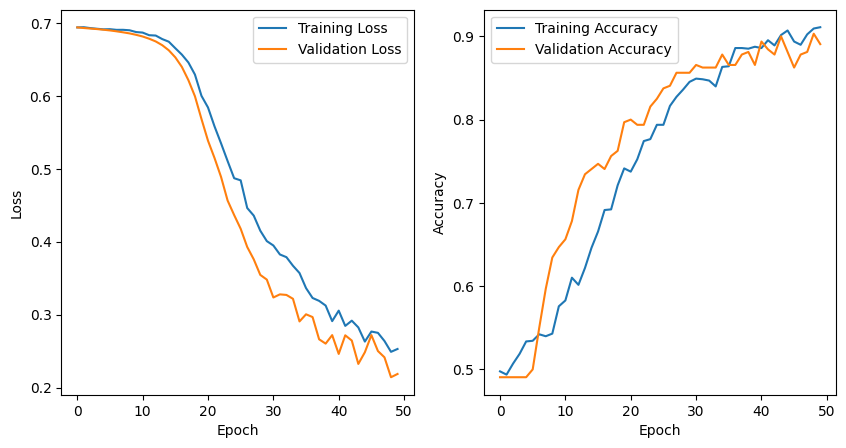

In [10]:
# Plot Losses and Accuracies
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Predicting the Test Set

In [11]:
# Predict the test dataset
all_labels, all_preds = [], []
model.eval()
total_loss = 0.0
with torch.no_grad():
  for videos, labels in tqdm(test_loader, desc="Test Loop"):
    videos, labels = videos.to(device), labels.to(device)

    outputs = model(videos)
    preds = outputs.argmax(dim=1).detach()
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

all_labels = [np.argmax(label) for label in all_labels]
acc = accuracy_score(all_labels, all_preds)

Test Loop:   0%|          | 0/13 [00:00<?, ?it/s]

In [12]:
print(f"Test set accuracy is {acc}")

Test set accuracy is 0.9275


              precision    recall  f1-score   support

           0       0.91      0.95      0.93       199
           1       0.95      0.91      0.93       201

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



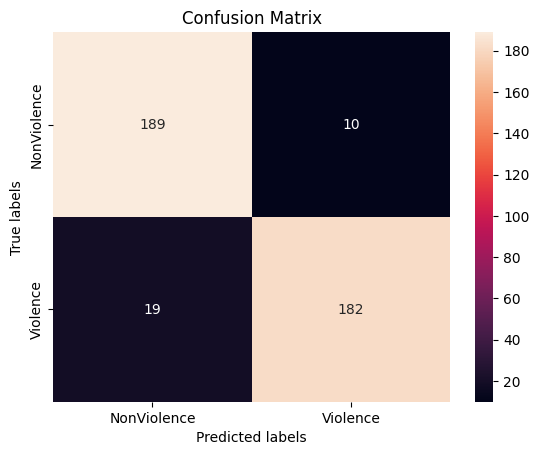

In [13]:
# Show the Classification Report and Confusion Matrix
print(classification_report(all_labels, all_preds))

ax= plt.subplot()
cm=confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NonViolence', 'Violence']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

# Predicting Random Videos From the Test Set

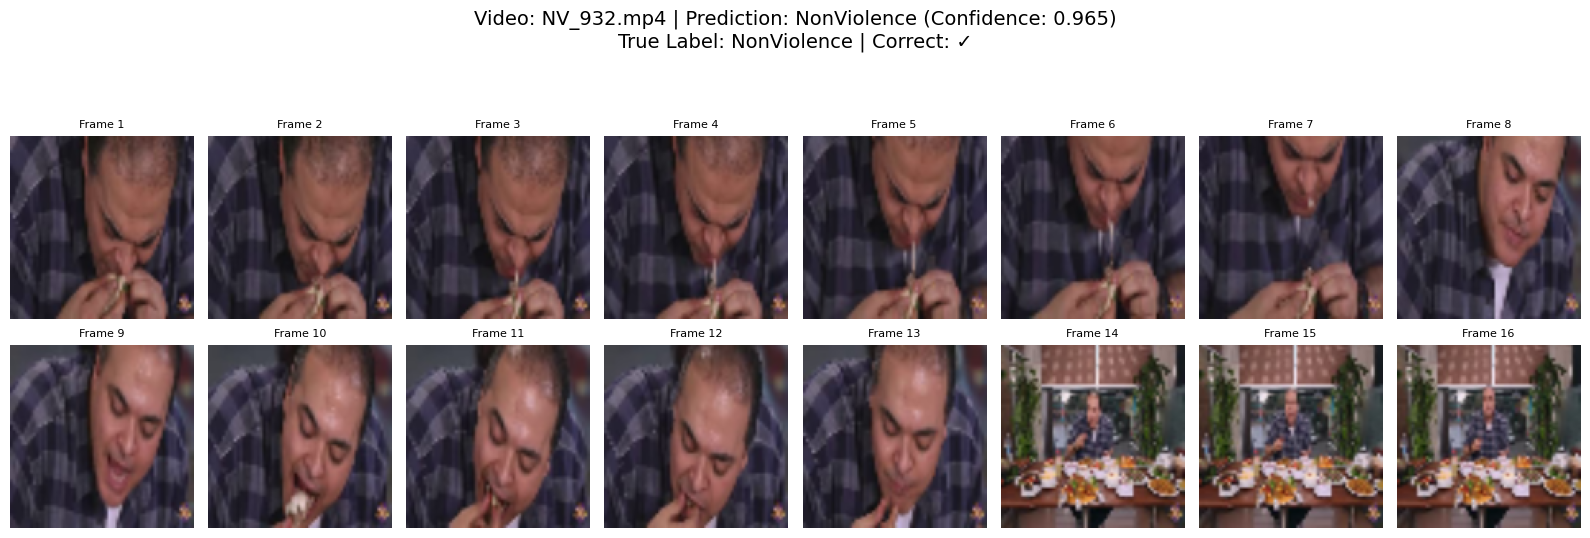

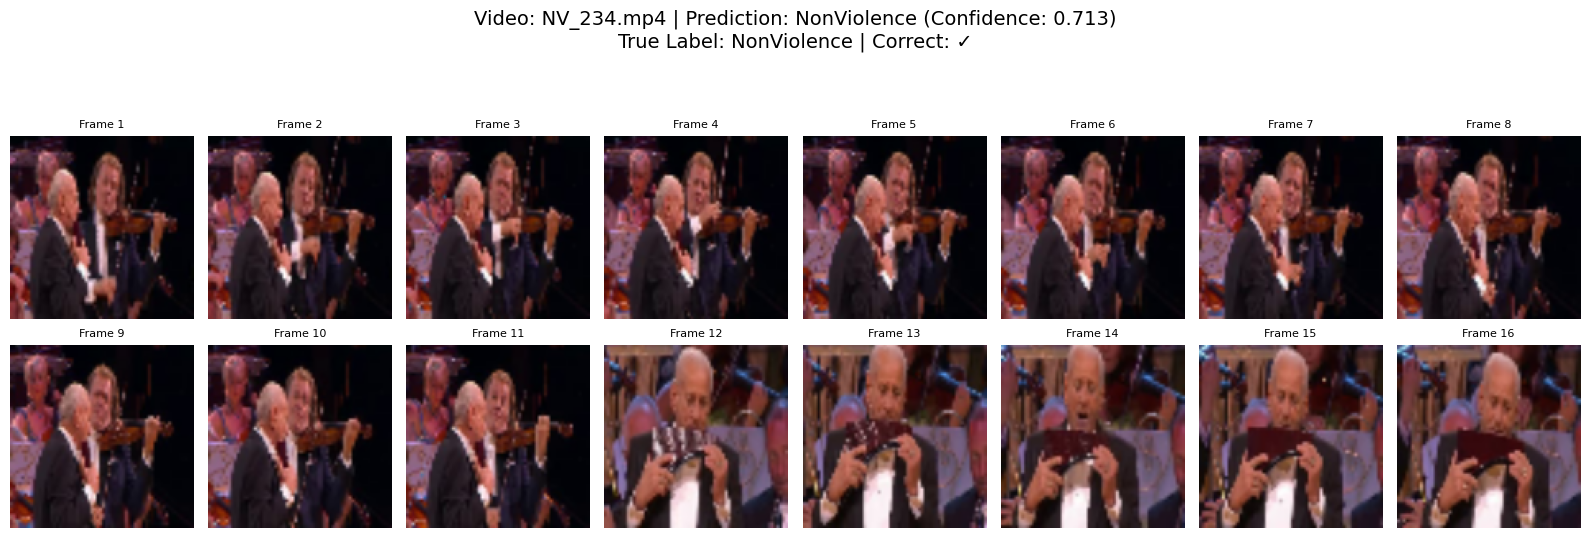

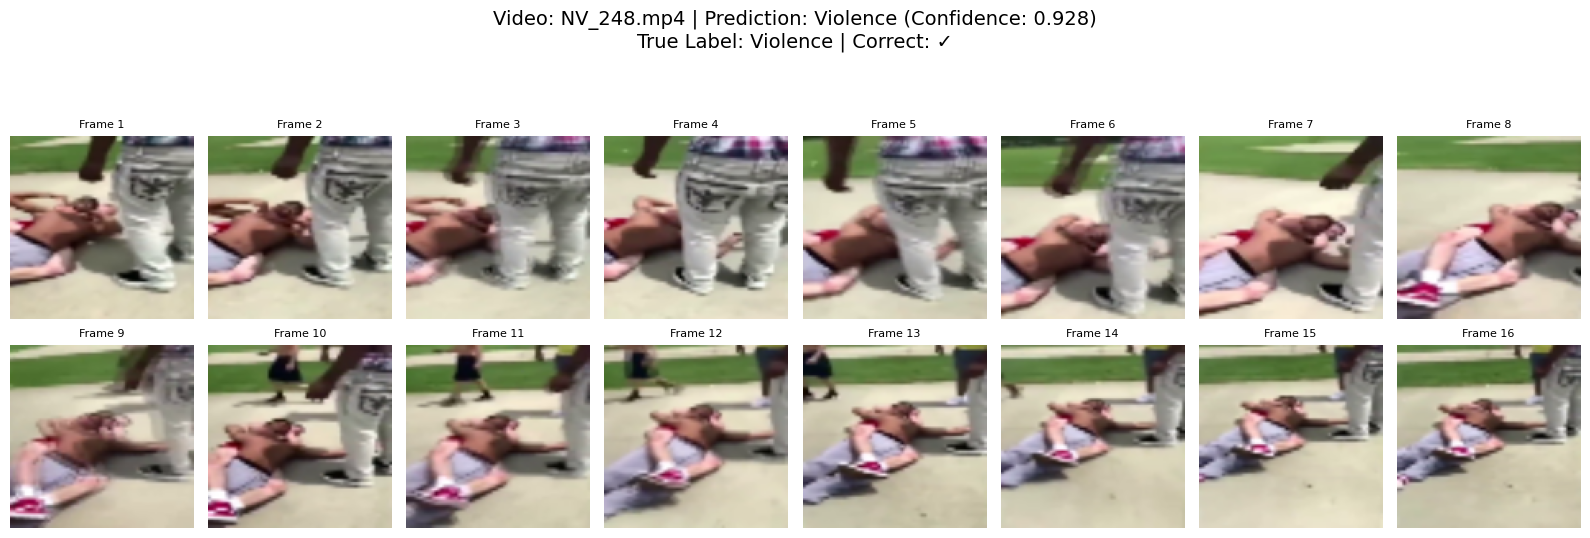

In [14]:
# Choose random indices
num_samples = 3  # or however many you want
indices = random.sample(range(len(features_test)), num_samples)

# Visualization function
def visualize_prediction(video, true_label, pred_label, confidence, video_path):
    plt.figure(figsize=(16, 6))
    plt.suptitle(
        f"Video: {video_path.split('/')[-1]} | "
        f"Prediction: {'Violence' if pred_label==1 else 'NonViolence'} "
        f"(Confidence: {confidence:.3f})\n"
        f"True Label: {'Violence' if true_label==1 else 'NonViolence'} | "
        f"Correct: {'✓' if pred_label == true_label else '✗'}",
        fontsize=14
    )

    for i, frame in enumerate(video):
        frame = frame[..., ::-1]    # fix color
        plt.subplot(2, 8, i+1)
        plt.imshow(frame)
        plt.axis("off")
        plt.title(f"Frame {i+1}", fontsize=8)
        border_color = 'green' if pred_label == true_label else 'red'
        for spine in plt.gca().spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(2)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run predictions and visualize
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for idx in indices:
    video = features_test[idx]  # shape: (16, 112, 112, 3)
    true_label = int(np.argmax(labels_test[idx]))
    video_tensor = torch.tensor(video).permute(0, 3, 1, 2).unsqueeze(0).float().to(device)  # (1, 16, 3, 112, 112)

    with torch.no_grad():
      output = model(video_tensor)         # raw logits, shape: (1, 1)
      probs = nn.functional.softmax(output, dim=1)         # shape [1, 2]
      prob_value, pred_label = torch.max(probs, dim=1)  # highest probability and its index

    # Convert to scalar
    pred_label = pred_label.item()      # 0 or 1
    prob_value = prob_value.item()      # confidence (0.0 to 1.0)
    visualize_prediction(video, true_label, pred_label, prob_value, video_files_paths[idx])